#                       MEDICAL APPOINTMENTS NO-SHOW

 
In this project, we will investigate the No-show appointments dataset. This original dataset collects information from 110.527 medical appointments in Brazil and is focused on the question of why patients do not show up for their appointment. This is a Kaggle competition, which can be found from here: https://www.kaggle.com/datasets/joniarroba/noshowappointments

In [1]:
import sys
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math

%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=100) # Adjust for higher-resolution figures

## DATA COLLECTION

**Loading the Dataset**

As the dataset is more than 10.2MB which is over the limit, so I deleted randomly the last 6881 data. Totally we have 103,639 medical appointments in this dataset (less than 10MB as required). 

In [2]:
df = pd.read_csv('missed_appointments.csv')

### Data Dictionary 

There are 14 variables in this dataset. 

01 - PatientId: Identification of a patient

02 - AppointmentID: Identification of each appointment

03 - Gender (Male or Female): Female is the greater proportion, woman takes way more care of they health in comparison to man.

04 - DataMarcacaoConsulta: The day of the actuall appointment, when they have to visit the doctor.

05 - DataAgendamento: The day someone called or registered the appointment, this is before appointment of course.

06 - Age: How old is the patient.

07 - Neighbourhood: Where the appointment takes place.

08 - Scholarship: True of False . Observation, this is a broad topic, consider reading this article https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

09 - Hipertension: True or False

10 - Diabetes: True or False

11 - Alcoholism: True or False

12 - Handcap: True or False

13 - SMS_received: 1 or more messages sent to the patient.

14 - No-show: True or False.

### Data Cleaning

In [3]:
# Check the types of 14 variables
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

Convert PatientID from string to integer for further analysis

In [4]:
df['PatientId']=df['PatientId'].astype(int)

#### Cleaning Datetime Variables for further analysis

Convert ScheduleDay and AppointmentDay from String to Datetime

In [5]:
df['AppointmentDay'] = df['AppointmentDay'].str[:10]
df['ScheduledDay'] = df['ScheduledDay'].str[:10]
import datetime as datetime
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

Create new column for "date of week" that the patient showed up for appointment. 
And create a new column for "Days", which calculate the number of days from Scheduled Day to the Appointment Day

In [6]:
#Create new column for "date of week" that the patient showed up for appointment.
df['Day_of_Week'] = pd.to_datetime(df['AppointmentDay']).dt.day_name()

#Calculate number of days from ScheduledDay to AppointmentDay:
df['Days']= df['AppointmentDay'] - df['ScheduledDay']

Remove any Days smaller than 0 from the Dataset

In [7]:
df = df[df['Days'] >= '0 days']

Extract the integer number of days from strings in Days Column. For example, extract "1" from "1 days". 

In [8]:
df['Days']=df['Days'].astype(str)
df['Days']=df['Days'].str.extract('(\d+)').astype(int)

Extract the Month of the Appointment Date

In [9]:
df['Month'] = pd.to_datetime(df['AppointmentDay']).dt.month

#### Cleaning other variables 

Check whether the Age of patient is smaller than 0 and remove those data

In [10]:
df[df['Age'] <0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Day_of_Week,Days,Month
99832,465943000000000,5775010,F,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No,Monday,0,6


In [11]:
#Remove the appointmentID 5775010 from the dataset, which has age =-1
df = df[df['AppointmentID']!=5775010]

In [12]:
#Check if there is any missing data
def count_missing_by_col(df):
    return df.isna().sum().to_frame(name="# of missing values ('NaNs')").T

count_missing_by_col(df)

#Alternatives: df.isnull().sum()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Day_of_Week,Days,Month
# of missing values ('NaNs'),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Check if there is any duplicate data
df.duplicated().sum()

0

In [14]:
#Check if there is any duplicated Appointment ID
df['AppointmentID'].duplicated().sum()

0

In [15]:
#Unique values for each column
df.nunique()

PatientId          59665
AppointmentID     103639
Gender                 2
ScheduledDay         111
AppointmentDay        27
Age                  103
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
Day_of_Week            6
Days                 129
Month                  3
dtype: int64

Create Age Group (under 17 years old, from 17 to 24, from 25 to 44, from 45 to 64, and over 65)

In [16]:
bin_edges = [0,17,24,44,64,115]
bin_names = ['under_17','17_to_24','25_to_44','45_to_64','65_and_over']
df['age_group'] = pd.cut(df['Age'],bin_edges,labels=bin_names)

Create Waiting Period (1 day, 2-14 days, 15-30 days, 31-60 days, 61-90 days, and over 90 days)

In [17]:
day_edges = [-1,1, 14, 30,60,90,179]
day_names = ['0_1days', '2_to_14days','15_to_30days','31_to_60days','61_to_90days','over_90days']
df['Waiting_Period'] = pd.cut(df['Days'],day_edges,labels=day_names)

In [18]:
# Calculate the number of chronic diseases:
df['Disease'] = df['Hipertension'] + df['Diabetes']

Now, we need to create a new variable "New_patient" to check whether the patient is a new or existing one

In [19]:
df_copy = (df.groupby(['PatientId']).size().sort_values(ascending=False).reset_index(name='count'))
df_copy['New_patient'] = 0
df_copy['New_patient'] = np.where(df_copy['count'] > 1, 0, 1)
del df_copy ['count']

#    Merge the df_copy with the df to get a combination of data

result = pd.merge(df, df_copy, on="PatientId", how="left")

Now, lets create another variable - Num_Missed: Number of Missed Appointments for each patient

In [20]:
result['Missed_Appointments_Yes'] = result['No-show'].apply(lambda x: 1 if x == "Yes" else 0)

#Number of Appointments missed by the same patient:
result['Num_Missed'] = result.groupby('PatientId')['Missed_Appointments_Yes'].apply(lambda x: x.cumsum())

**Let's take a quick look at what the data looks like**

In [21]:
result.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,No-show,Day_of_Week,Days,Month,age_group,Waiting_Period,Disease,New_patient,Missed_Appointments_Yes,Num_Missed
0,29872500000000,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,No,Friday,0,4,45_to_64,0_1days,1,0,0,0
1,558998000000000,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,No,Friday,0,4,45_to_64,0_1days,0,0,0,0
2,4262960000000,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,...,No,Friday,0,4,45_to_64,0_1days,0,0,0,0
3,867951000000,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,No,Friday,0,4,under_17,0_1days,0,0,0,0
4,8841190000000,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,No,Friday,0,4,45_to_64,0_1days,2,1,0,0


Let's look at the descriptive analysis of the dataset. 

In [22]:
result.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Days,Month,Disease,New_patient,Missed_Appointments_Yes,Num_Missed
count,1.036390e+05,1.036390e+05,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000,103639.000000
mean,1.473079e+14,5.671069e+06,37.013605,0.099104,0.197956,0.072280,0.029101,0.022135,0.313801,10.249867,5.157595,0.270236,0.354780,0.202221,0.403449
std,2.557873e+14,7.041359e+04,23.175891,0.298803,0.398461,0.258952,0.168091,0.160605,0.464039,15.355699,0.441802,0.561666,0.478449,0.401658,0.795229
min,3.920000e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,4.175520e+12,5.638462e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,3.174220e+13,5.677045e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439380e+13,5.718894e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,5.000000,0.000000,1.000000,0.000000,1.000000
max,9.999820e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000,6.000000,2.000000,1.000000,1.000000,18.000000


In [23]:
# Percentage of Female/Male
pd.crosstab(df['No-show'],df['Gender']).apply(lambda r: r/r.sum(), axis=1)

Gender,F,M
No-show,,
No,0.649992,0.350008
Yes,0.655311,0.344689


In [24]:
df.groupby(by=["No-show"]).size()

No-show
No     82681
Yes    20958
dtype: int64

## DATA ANALYSIS

**What is the percentage of No-shows appointment?**
As the variable "No-show" is misleading, we will rename the variable as "Missed_Appointments" for better clarification.

In [25]:
result.rename(columns = {'No-show':'Missed_Appointments'}, inplace = True)

pd.DataFrame({'Percentage': result.groupby(('Missed_Appointments')).size() / len(result)})

,Percentage
Missed_Appointments,
No,0.797779
Yes,0.202221


From the Data Descriptive, a total of 103,639 visits (mean age of 37.01 of which around 65% were female) were included. There were 20958 of no-show visits, the overall proportion of no-shows at all outpatients’ clinics was (20.22%). 

From the above calculation, we could see that the percentage of the missed-appointments is 20%. 


### 1. ANALYSIS BY DATA VISUALIZATION 

**SO, WHICH FACTORS MAY AFFECT THE MISSING APPOINTMENTS?**

Now we will see whether these following variables affect the missed appointments?

1. Does gender affect the missed appointments?
2. Does the number of disease affect the missed appointments?
3. Does the level of alcholism affect the missed appointments?
4. Does the level of handicap affect the missed appointments?
5. Does the SMS received factor affect the missed appointments?
6. Does the age_group affect the missed appointments?
7. Does the waiting period affect the missed appointments?
8. Does day of the week (Monday-Friday) affect the missed appointments? 
9. Does the Month of the appointment date affect the missed appointments? 
10. Does the existing patient tend to miss the appointments more? 
11. Does the scholarship affect the missed appointments?
12. Does the previous number of missed appointments per patient affect the missed appointments?

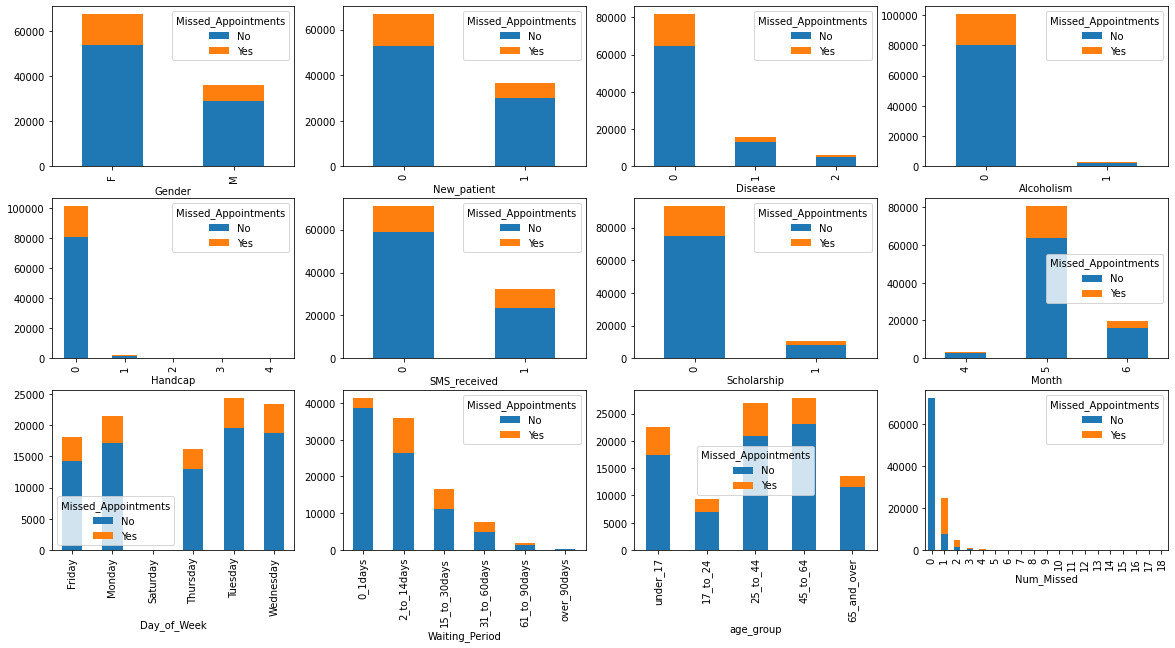

In [26]:
#First, let's look at categorical variables
factors = ['Gender','New_patient','Disease', 'Alcoholism', 'Handcap', 'SMS_received', 'Scholarship', 'Month', 'Day_of_Week', 'Waiting_Period', 'age_group','Num_Missed']

fig = plt.figure(figsize=(20, 10))
for x, y in enumerate(factors):
    ax1 = fig.add_subplot(3, 4, x+1)
    result.groupby([y, 'Missed_Appointments'])[y].count().unstack('Missed_Appointments').plot(ax=ax1, kind='bar', stacked=True)

Among those above chart, we could see that Num_Missed variable (number of missed appointments per patient) seems to have a significant influence over the Missed_Appointments variable. Let's take a more detailed look at the chart:

** From the above data visualization, we have the following conclusion: **

1. Gender: Female are more likely to miss the hospital appointments than Male. But this maybe due to the fact that more women make appointment than men. 
2. Diseases: People without any chronic diseases (Hypertension and Diabetes) are more likely to skip the appointments.
3. Alcoholism: People with alcoholism are more likely to miss the appointments.
4. Handicapped: People without handicapped are more likely to miss the appointments.
5. SMS Received: People who receive the SMS are more likely to miss the appointments. This is very interesting as the SMS's purpose is to remind them of the appointments.
6. Age group: Young people (under 17 years old and from 25-64 years old) are more likely to miss the appointments.
7. Day of the week: People are more likely to miss the appointment if that appointment falls into Monday, Tuesday and Wednesday. 
8. Waiting Period: People are more like to miss the appointment if those appointments are scheduled within 2 to 14 days. 
9. Month: People are more like to book appointment as well as miss the appointments in May.
10. New Patient: The established patient tends to miss the appointment more than the new one. 
11. Scholarship: Interestingly, patient with scholarship tends to skip the appointments more. This is a social welfare program of the Government of Brazil, part of the Fome Zero network of federal assistance programs. Bolsa Família provided financial aid to poor Brazilian families. 
12. Number of missed appointments: People are more likely to miss appointments if they used to do so previously. 


In [27]:
#!pip install scikit-learn==0.23.1
#!pip uninstall scikit-learn --yes

### 2. ANALYSIS BY LOGISTIC REGRESSION

*Logistic regression was used to develop a no-show predictive model, which was then used to construct an algorithm to determine the no-show threshold that calculates a predicted show/no-show status.*

In [28]:
#Convert variables to Binary data for column (Month, Day of the week, Waiting_Period, age_group, Neighborhood):
df1 = pd.get_dummies(result, columns=['Month', 'Waiting_Period','age_group'], drop_first=True, prefix_sep='_')
# Convert Gender variables to dummy variable (1 if Gender is Female and 0 if Gender is Male)
df1['Gender_F'] = df1.Gender.apply(lambda x: 1 if x == "F" else 0)
df1.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,Waiting_Period_2_to_14days,Waiting_Period_15_to_30days,Waiting_Period_31_to_60days,Waiting_Period_61_to_90days,Waiting_Period_over_90days,age_group_17_to_24,age_group_25_to_44,age_group_45_to_64,age_group_65_and_over,Gender_F
0,29872500000000,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,0,0,0,0,0,0,0,1,0,1
1,558998000000000,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4262960000000,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,867951000000,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,8841190000000,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,0,0,0,0,0,0,0,1,0,1


In [29]:
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score

With the data visualization, we have remove some of the non-related variables from independent variables such as PatientID, AppointID, Schedule Day, Appointment Day, Age, Neighborhood. We include other variables in the model, as from our data visualization, we could see that there are correlations between those variables and the Missed_Appointment Variable. 

In [30]:
#Create a matrix of independent variable
df1_c =  df1.drop(['PatientId', 'AppointmentID', 'ScheduledDay','Days','Day_of_Week', 'AppointmentDay', 'Gender', 'Neighbourhood', 'Missed_Appointments'], axis=1)
df1_c.columns.values

array(['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism',
       'Handcap', 'SMS_received', 'Disease', 'New_patient',
       'Missed_Appointments_Yes', 'Num_Missed', 'Month_5', 'Month_6',
       'Waiting_Period_2_to_14days', 'Waiting_Period_15_to_30days',
       'Waiting_Period_31_to_60days', 'Waiting_Period_61_to_90days',
       'Waiting_Period_over_90days', 'age_group_17_to_24',
       'age_group_25_to_44', 'age_group_45_to_64',
       'age_group_65_and_over', 'Gender_F'], dtype=object)

In [31]:
# Independent Variables
X = df1_c.drop(['Missed_Appointments_Yes','Disease','Age'], axis = 1)

#Dependent Variables
y=df1_c['Missed_Appointments_Yes']

X

,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,New_patient,Num_Missed,Month_5,Month_6,Waiting_Period_2_to_14days,Waiting_Period_15_to_30days,Waiting_Period_31_to_60days,Waiting_Period_61_to_90days,Waiting_Period_over_90days,age_group_17_to_24,age_group_25_to_44,age_group_45_to_64,age_group_65_and_over,Gender_F
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103634,0,1,0,0,0,1,0,2,0,1,0,1,0,0,0,0,0,1,0,0
103635,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
103636,1,1,1,0,0,0,0,2,0,1,0,1,0,0,0,0,0,1,0,1
103637,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


### FEATURE SELECTION


In [32]:
from sklearn.feature_selection import RFE
names = X.columns.values
logreg = LogisticRegression(solver='lbfgs',max_iter=10000)
rfe=RFE(logreg)
rfe=rfe.fit(X, y)
print("Features sorted by rank:")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_),names)))

Features sorted by rank:
[(1, 'Month_5'), (1, 'Month_6'), (1, 'New_patient'), (1, 'Num_Missed'), (1, 'Waiting_Period_15_to_30days'), (1, 'Waiting_Period_2_to_14days'), (1, 'Waiting_Period_31_to_60days'), (1, 'Waiting_Period_61_to_90days'), (1, 'Waiting_Period_over_90days'), (1, 'age_group_65_and_over'), (2, 'age_group_45_to_64'), (3, 'Alcoholism'), (4, 'age_group_25_to_44'), (5, 'Diabetes'), (6, 'Handcap'), (7, 'Gender_F'), (8, 'age_group_17_to_24'), (9, 'SMS_received'), (10, 'Hipertension'), (11, 'Scholarship')]


### TRY A LOT OF MODELS TO FIND THE BEST ONE 

In [33]:
#Try only the top feature:
X1 = df1[['Num_Missed','New_patient','Days','Age', 'Handcap','Scholarship','Alcoholism','Disease','Gender_F','Month_5','Month_6','SMS_received']]

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

models = []
names = []
scoring = 'accuracy'
seed = 7
models.append(('LR', LogisticRegression(solver='lbfgs',max_iter=10000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))

def calculate_accuracy(X, y):
    results = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s:\t%0.3f (+/- %0.3f)" % (name, cv_results.mean(), cv_results.std() * 2)
        print(msg)
    return results
all_features = calculate_accuracy(X1,y)

LR:	0.895 (+/- 0.005)
LDA:	0.862 (+/- 0.007)
NB:	0.838 (+/- 0.006)
KNN:	0.895 (+/- 0.005)


**IMPLEMENT THE LOGISTIC REGRESSION MODEL**

From the above result, I decided to choose Logistic Regression Model to predict the no-show appointments

In [35]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X1)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Optimization terminated successfully.
         Current function value: 0.292964
         Iterations 7
                             Results: Logit
Model:              Logit                   Pseudo R-squared: 0.418     
Dependent Variable: Missed_Appointments_Yes AIC:              60748.9767
Date:               2022-05-12 17:15        BIC:              60863.5607
No. Observations:   103639                  Log-Likelihood:   -30362.   
Df Model:           11                      LL-Null:          -52179.   
Df Residuals:       103627                  LLR p-value:      0.0000    
Converged:          1.0000                  Scale:            1.0000    
No. Iterations:     7.0000                                              
--------------------------------------------------------------------------
                Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------------
Num_Missed      3.0294     0.0213    142.3796

In [36]:
#We can normalize the dataset using the following function. 
#However, in this case, I do not normalize the dataset as we don't need to normalize dataset in logistic regression.
# CODE FOR NORMALIZE DATASET
#from sklearn import preprocessing
#X = preprocessing.StandardScaler().fit(X).transform(X)
#X[:1]

**Train/Test dataset**

We split our dataset into train and test set:

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X1, y, test_size=0.33, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (69438, 12) (69438,)
Test set: (34201, 12) (34201,)


Let's build our model using LogisticRegression from the Scikit-learn package. 

In [38]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

y_pred_class = LR.predict(X_test)

print('intercept ', LR.intercept_[0])
print('Accuracy score: ',metrics.accuracy_score(y_test, y_pred_class))

intercept  -2.561845906569198
Accuracy score:  0.8897400660799392


In [39]:
print (classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     27301
           1       0.81      0.59      0.68      6900

    accuracy                           0.89     34201
   macro avg       0.86      0.78      0.81     34201
weighted avg       0.88      0.89      0.88     34201



Based on above classification report, we can can see the precision and recall of each label:

 - Precision is a measure of the accuracy provided that a class label has been predicted. 

                       Precision = TP / (TP + FP)

 - Recall is the true positive rate. 
 
                       Recall =  TP / (TP + FN)


 - F1 score: the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. 
 
The accuracy for this classifier is the average of the F1-score for both labels, which is 0.69 in our case.

**predict_proba** returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):

In [40]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.95256987, 0.04743013],
       [0.5422766 , 0.4577234 ],
       [0.9685136 , 0.0314864 ],
       ...,
       [0.95606381, 0.04393619],
       [0.94333618, 0.05666382],
       [0.94754286, 0.05245714]])

** From Logistic Regression model's results, we only focus on the coefficients which are statistically significant (associated with a p-value <0.05), so our model suggests the following influence over the missed appointments:** 

 
1. Age: Age is negatively correlated with the Missed Appointments, which means that the younger patients tend to miss the appointment more than old patients. 
2. Scholarship: Patient with scholarship tends to miss the appointments more.
3. Chronic illness: Interestingly, patients with chronic illnesses such as Hypertension and Diabetes tend to miss the appointments more.
4. Handicapped: People without handicapped tend to miss the appointments more. 
5. SMS Received: People who receive the SMS are more likely to miss the appointments. 
6. Days: People tends to miss the appointments more if the duration from the scheduled date and the appointment date is longer. 
7. Gender: Male are more likely to miss the appointment than female. This maybe because female are more health-concerned than male. 
8. New Patient: Interestingly, the new patient tends to miss the appointment more than the established one.
9. Number of missed appointments: People are more likely to miss appointments if they used to do so previously.


Since the accuracy score is 0.89 and F1 score is 0.68, this is a good model to predict whether the patient shows up for the medical appointments or not.


**CONCLUSION AND LIMITATIONS**


In this study, we attempt to identify the key factors to predict patients who will not attend the appointment (no shows) using regular available hospital data. The main factors of no-show with the reasons such as whether they are new patients or established patients, whether they receive scholarships, whether they are old or have chronic illness, whether they missed the previous appointments, or whether the waiting period is long, etc. Other important factor for no-show is the distance, which we did not study in this case. If the distance from the patient's house to the medical office is long, it is more likely that the patient will miss the hospital appointment. Another limitation is that the model should include such factors as health insurance (patient has insurance or not) to make the model more accurate. 